In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import erf
import emcee
from scipy.optimize import root_scalar
import agama
import corner
import astropy.coordinates as coord
import astropy.units as u
import multiprocessing

In [2]:
agama.setUnits(length=1, mass=1e10, velocity=1)
# 常数和参数（单位：kpc, Gyr, 10^10 Msun）
G = 43018  # 单位转换后：kpc³/(10¹⁰ Msun·Gyr²)
M_bulge = 1.0    # 10¹⁰ Msun (原1e10 Msun)
M_disk = 6.8    # 10¹⁰ Msun (原5e10 Msun)
a_disk = 3.     # kpc
a_bulge = 0.5 
#v_disper = 90

In [ ]:
def g_concen(a,r):
    return np.log(1+r/a) - r/(a+r)

def cal_potential(a_halo, den_halo, a_LMC):
    #rlmc_200 = (43018*M_LMC)**(1/3) 
    M_LMC = 1.7*(a_LMC+8.7)**2/8.7**2
    #c_LMC = rlmc_200/rlmc_scal
    #a_LMC = rlmc_scal*np.sqrt(2*(np.log(1+c_LMC)-c_LMC/(1+c_LMC)))
    para_halo = agama.Density(type='Spheroid', densityNorm=den_halo, scaleRadius=a_halo, gamma = 1,beta = 3,outerCutoffRadius=300,cutoffStrength=4)
    para_bulge = agama.Density(type='Dehnen', mass=M_bulge, scaleRadius=a_bulge, gamma = 1)
    LMCpot = agama.Potential(type='Dehnen', mass=M_LMC, scaleRadius=a_LMC, gamma = 1)
    # potential
    MWpot = agama.Potential(type='Multipole',density=para_bulge+para_halo,
                                        lmax=4, gridSizeR=5000, rmin=1e-1, rmax=500)


    M_close = 4*np.pi*den_halo*a_halo**3*g_concen(a_halo,2.16*a_halo)
    V_max = (G*M_close/2.16/a_halo)**0.5
    #print('V_max:', V_max, 'M_close:', M_close, 'M_LMC:', M_LMC)
    return MWpot, LMCpot, M_LMC, V_max


def rotation_matrix_x(theta):
    """
    绕 x 轴旋转的旋转矩阵 (角度 theta)
    参数:
        theta: 绕 x 轴旋转的角度 (弧度)
    返回:
        3x3 旋转矩阵
    """
    return np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    
def rotation_matrix_y(phi):
    """
    绕 y 轴旋转的旋转矩阵 (角度 phi)
    参数:
        phi: 绕 y 轴旋转的角度 (弧度)
    返回:
        3x3 旋转矩阵
    """
    return np.array([
        [np.cos(phi), 0, np.sin(phi)],
        [0, 1, 0],
        [-np.sin(phi), 0, np.cos(phi)]
    ])

def rotation_matrix_z(phi):
    """
    绕 z 轴旋转的旋转矩阵 (角度 phi)
    参数:
        phi: 绕 z 轴旋转的角度 (弧度)
    返回:
        3x3 旋转矩阵
    """
    return np.array([
        [np.cos(phi), -np.sin(phi), 0],
        [np.sin(phi), np.cos(phi), 0],
        [0, 0, 1]
    ])

#坐标系转换
def Galactic_to_icrs(pos,vel):
    gc = coord.SkyCoord(x= pos[0]* u.kpc, y=pos[1]* u.kpc,
            z= pos[2]* u.kpc,
            v_x= vel[0]* u.km / u.s,
            v_y= vel[1]* u.km / u.s,
            v_z= vel[2]* u.km / u.s, frame='galactocentric',
            representation_type='cartesian', differential_type='cartesian',
            galcen_distance=8.122* u.kpc, z_sun=20.8 * u.pc,
            galcen_v_sun=coord.CartesianDifferential(
                 [12.9, 245.6, 7.8] * u.km / u.s))
    c = gc.transform_to(coord.ICRS)
    ra = np.array(c.ra)
    dec = np.array(c.dec)
    distance = np.array(c.distance)
    pmra = np.array(c.pm_ra_cosdec)
    pmdec = np.array(c.pm_dec)
    vr = np.array(c.radial_velocity)
    return ra, dec, distance, pmra, pmdec, vr


# 微分方程组
def LMC_back_equation(t, y, MWpot, a_halo, V_max, LMCpot, M_LMC):

    r_LMC = y[0:3]
    v_LMC = y[3:6]
    v_norm = np.linalg.norm(v_LMC)  # 避免除零
    r_norm = np.linalg.norm(r_LMC)  # 避免除零

    rs_LMC = 8.5*(M_LMC/10)**0.6
    ln_Lambda = np.log(r_norm/(2.2*rs_LMC-14)) # 度量参数

    # 根据 Hernquist 分布计算 rho_halo
    rho_halo = MWpot.density(r_LMC)  # 计算银河系的密度
    # 计算 X 和误差函数项
    
    sigma = V_max*1.4393*(r_norm/a_halo)**0.354/(1+1.1756*(r_norm/a_halo)**0.752)*np.exp(-0.5*(r_norm/300)**2.5)
    
    X_c = v_norm / (2**0.5 * sigma)  # 假设速度分散为 200 km/s
    erf_term = erf(X_c) - 2 * X_c / np.sqrt(np.pi) * np.exp(-X_c**2)

    acc_disk = - G * M_disk * (1-(r_norm/a_disk+1)/np.exp(r_norm/a_disk)) * r_LMC / r_norm**3

    # 动力摩擦力
    a_df  = -4 * np.pi * G**2 * M_LMC * rho_halo * ln_Lambda * erf_term * v_LMC / v_norm**3
    
    # LMC的加速度
    acc_LMC = MWpot.force(r_LMC) - a_df + LMCpot.force(r_LMC) + acc_disk
    

    
    return np.concatenate((v_LMC, acc_LMC))




# 定义运动学模型
def LMC_ini(MWpot, a_halo, V_max, LMCpot, M_LMC):

    pos = np.array([-0.6143609652013762,-41.02036741646231, -26.832974651917674])
    vel = np.array([69.81047009397867, 221.9356211949808, -214.01029566668603])
    # 时间范围（Gyr）
    t_back = (0, 3)  # 积分Gyr
    # 初始条件
    y0 = np.concatenate((pos, vel))
    #print(y0.shape)

    # 求解ODE
    sol = solve_ivp(LMC_back_equation, t_back, y0, method='RK45', rtol=1e-7, 
                    args=(MWpot, a_halo, V_max, LMCpot, M_LMC,),t_eval=np.linspace(t_back[0], t_back[1], 1000))#MWpot, LMCpot, a_LMC, M_LMC
    final_pos = sol.y[:3, -1]  # 最后一列是位置 [x, y, z]
    final_vel = sol.y[3:, -1]  # 最后一列是速度 [vx, vy, vz]

    final_pos = np.array(final_pos)
    final_vel = np.array(final_vel)
    
    
    return final_pos, final_vel

# 定义二体问题的微分方程
def two_body_equation(t, y, M, MWpot, a_halo, V_max, LMCpot,  M_LMC, M_halo):
    """
    二体问题的微分方程
    参数:
        t: 时间 (Gyr)
        y: 状态向量 [x, y, z, vx, vy, vz]
        M: 中心天体质量 (10^10 Msun)
    返回:
        dydt: 状态向量的导数 [vx, vy, vz, ax, ay, az]
    """
    r_lmc = y[:3]  # 位置 [x, y, z]
    v_lmc = y[3:6]  # 速度 [vx, vy, vz]
    r_m31 = y[6:9]  # 位置 [x, y, z]
    v_m31 = y[9:12]  # 速度 [vx, vy, vz]
    

    r_norm_lmc = np.linalg.norm(r_lmc)  # 避免除零
    r_norm_m31 = np.linalg.norm(r_m31)  # 避免除零
    v_norm_lmc = np.linalg.norm(v_lmc)  # 避免除零
    v_norm_m31 = np.linalg.norm(v_m31)  # 避免除零
    
    rs_LMC = 8.5*(M_LMC/10)**0.6
    ln_Lambda = np.log(r_norm_lmc/(2.2*rs_LMC-14)) # 度量参数

    # 根据 Hernquist 分布计算 rho_halo
    rho_halo = MWpot.density(r_lmc)  # 计算银河系的密度
    # 计算 X 和误差函数项
    sigma = V_max*1.4393*(r_norm_lmc/a_halo)**0.354/(1+1.1756*(r_norm_lmc/a_halo)**0.752)*np.exp(-0.5*(r_norm_lmc/300)**2.5)
    X_c = v_norm_lmc / (2**0.5 * sigma)  # 假设速度分散为 200 km/s
    erf_term = erf(X_c) - 2 * X_c / np.sqrt(np.pi) * np.exp(-X_c**2)

    # 动力摩擦力
    a_df  = -4 * np.pi * G**2 * M_LMC * rho_halo * ln_Lambda * erf_term * v_lmc / v_norm_lmc**3

    acc_disk = - G * M_disk * (1-(r_norm_lmc/a_disk+1)/np.exp(r_norm_lmc/a_disk)) * r_lmc / r_norm_lmc**3
    
    a_m31 = -G * (M+M_LMC) * r_m31 / r_norm_m31**3  + LMCpot.force(r_lmc) #+ a_df*M_LMC / (M_halo+M_LMC)
    #G * M_LMC * (r_m31-r_lmc) / np.linalg.norm(r_m31 - r_lmc)**3
    a_lmc = MWpot.force(r_lmc) + a_df + LMCpot.force(r_lmc) + acc_disk

    return np.concatenate((v_lmc, a_lmc, v_m31, a_m31))

# 定义轨道模型
def orbit_model(params):
    
    a, e, M, a_halo, a_LMC, eta, theta, phi, alpha = params
    # 计算轨道周期
    
    T = np.sqrt(a**3 / (G * M))  # 单位：Gyr
    # 计算时间 t
    t = T * (eta - e * np.sin(eta)) 

    # 计算 r, v_rad, v_tan
    r = a * (1 - e * np.cos(eta))
    v_factor = np.sqrt(G * M / a)
    v_rad = v_factor * (e * np.sin(eta)) / (1 - e * np.cos(eta))
    v_tan = v_factor * np.sqrt(1 - e**2) / (1 - e * np.cos(eta))
    
    den_halo = 4.2/g_concen(a_halo,8.2)/4/np.pi/a_halo**3


    MWpot, LMCpot, M_LMC, V_max = cal_potential(a_halo,den_halo, a_LMC)
    
    # 计算位置和速度
    Rot_mat = np.dot(rotation_matrix_y(theta), np.dot(rotation_matrix_z(phi), rotation_matrix_x(alpha)))
    pos_m31 = np.dot(Rot_mat, np.array([r , 0, 0]))
    vel_m31 = np.dot(Rot_mat, np.array([v_rad, v_tan, 0]))
    pos_lmc, vel_lmc = LMC_ini(MWpot,  a_halo, V_max, LMCpot, M_LMC)
    vel_lmc = -vel_lmc
    #print(pos_lmc, vel_lmc,a_LMC)
    #print(pos_m31, vel_m31)
    # 计算相对位置和速度
    y0 = np.concatenate((pos_lmc, vel_lmc, pos_m31, vel_m31))
    
    # 时间范围（Gyr）
    t_forward = (0, 3)  # 积分Gyr
    # 求解ODE
    sol = solve_ivp(two_body_equation, t_forward, y0, method='RK45', rtol=1e-7, 
                    args=(M, MWpot, a_halo, V_max, LMCpot, M_LMC, den_halo, ),t_eval=np.linspace(t_forward[0], t_forward[1], 1000))
    
    final_pos = sol.y[6:9, -1]  # 最后一列是位置 [x, y, z]
    final_vel = sol.y[9:12, -1]  # 最后一列是速度 [vx, vy, vz]
    
    ra, dec, distance, pmra, pmdec, vr = Galactic_to_icrs(final_pos, final_vel)
    
    #pv_lmc = Galactic_to_icrs(sol.y[:3, -1], sol.y[3:6, -1])
    #print(pv_lmc)
    
    return ra, dec, distance, pmra, pmdec, vr, t+3 # 返回位置和速度




In [5]:
params = [700, 0.9, 300, 16, 20, 3.14, np.pi/2, np.pi/4,0] # a, e, M, a_halo, M_LMC, q_MW, eta, theta, phi, alpha
ra, dec, distance, pmra, pmdec, vr, t  = orbit_model(params)
print(ra, dec, distance, pmra, pmdec, vr,t)


348.05720461100907 14.415275130930768 1261.9165657852527 0.01414722012592126 -0.015923660333174484 -255.43821956057778 19.180527485657134


In [14]:

# 定义似然函
def log_likelihood(params, data, obs_err):
    """
    计算似然函数
    参数:
        params: 轨道参数 
        data: 观测数据，包括位置、速度等
    返回:
        似然值
    """
    # 从数据中提取观测值
    obs_ra, obs_dec, obs_distance, obs_pmra, obs_pmdec, obs_vr, time_u = data
    obs_ra_err, obs_dec_err, obs_distance_err, obs_pmra_err, obs_pmdec_err, obs_vr_err, time_u_err = obs_err
    
    # 计算模型值
    model_ra, model_dec, model_distance, model_pmra, model_pmdec, model_vr, t = orbit_model(params)
    
    # 计算似然
    chi2 = (model_ra - obs_ra)**2 / obs_ra_err**2 + \
        (model_dec - obs_dec)**2 / obs_dec_err**2 + \
        (model_distance - obs_distance)**2 / obs_distance_err**2 + \
        (model_pmra - obs_pmra)**2 / obs_pmra_err**2 + \
        (model_pmdec - obs_pmdec)**2 / obs_pmdec_err**2 + \
        (model_vr - obs_vr)**2 / obs_vr_err**2 + \
        (t - time_u)**2 / time_u_err**2

    return -0.5 * chi2

# 定义先验函数
def log_prior(params):
    """
    定义参数的先验分布
    参数:
        params: [M_LG, r, ln(1-e), eta, alpha]
    返回:
        log_prior: 对数先验值
    """
    a, e, M, a_halo, a_LMC, eta, theta, phi, alpha = params
    
        # 先验分布

    # r: 正态分布 N(700, 100)
    if a <= 0:
        return -np.inf
    log_prior_r = -0.5 * ((a - 700) / 100)**2

    # ln(1-e): 均匀分布 U(-10, 0)
    if e < 0 or e >= 1:
        return -np.inf
    log_prior_e = 0  # 均匀分布的对数先验为常数
    
    # M_LG: 正态分布 N(4.5e12, 3e12)
    if M <= 0:
        return -np.inf
    log_prior_M_LG = -0.5 * ((M - 400) / 300)**2
    
    # M_halo: 正态分布 N(92.6, 13.3)
    if a_halo <= 0:
        return -np.inf
    log_prior_a_halo = -0.5 * ((a_halo - 16) / 8)**2
    
    # M_LMC: 正态分布 N(13.3, 3)
    if a_LMC <= 12 or a_LMC >= 30:
        return -np.inf
    log_prior_a_LMC = 0

    # q_MW: 均匀分布 U(0.46, 0.54)
   # if q_MW < 0.5 or q_MW > 2:
   #     return -np.inf
   # log_prior_q_MW = 0  # 均匀分布的对数先验为常数


    # eta: 均匀分布 U(0, 2*pi)
    if eta < 0 or eta > 2*np.pi:
        return -np.inf
    log_prior_eta = 0  # 均匀分布的对数先验为常数

    # theta: 均匀分布 U(0, pi)
    if theta < np.pi/2 or theta > 3*np.pi/2:
        return -np.inf
    log_prior_theta = 0  # 均匀分布的对数先验为常数
    
    # phi: 均匀分布 U(0, pi)
    if phi < 0 or phi > np.pi/2:
        return -np.inf
    log_prior_phi = 0  # 均匀分布的对数先验为常数
    
    #alpha: 均匀分布 U(0, 2*pi)
    if alpha < 0 or alpha > 2*np.pi:
        return -np.inf
    log_prior_alpha = 0  # 均匀分布的对数先验为常数
    # 计算总的对数先验
    log_prior_total = log_prior_M_LG + log_prior_r + log_prior_e + \
                    log_prior_a_halo + log_prior_a_LMC + log_prior_eta + \
                    log_prior_theta + log_prior_phi + log_prior_alpha #+ log_prior_q_MW
    return log_prior_total


def log_posterior(params, data, obs_errors):
    """
    计算后验分布
        log_posterior: 对数后验值
    """
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, data, obs_errors)

In [18]:
obs_time = 13.8
obs_time_err = 0.024
obs_ra = 10.68
obs_ra_err = 0.1
obs_dec = 41.27
obs_dec_err = 0.1
obs_distance = 761
obs_distance_err = 11
obs_pmra = 46.9*1e-3
obs_pmra_err = 10*1e-3
obs_pmdec = -29.1*1e-3
obs_pmdec_err = 10*1e-3
obs_vr = -301
obs_vr_err = 1

data = [obs_ra, obs_dec, obs_distance, obs_pmra, obs_pmdec, obs_vr, obs_time]
obs_err = [obs_ra_err, obs_dec_err, obs_distance_err, obs_pmra_err, obs_pmdec_err, obs_vr_err, obs_time_err]


# MCMC 采样
ndim = 9  # 参数维度
nwalkers = 45 # walker 数量
nsteps = 5000  # 采样步数
ncores = 20  # CPU 核心数

# 初始参数
initial_guess = [700, 0.5, 300, 16, 20, 3.14, np.pi*0.75, np.pi/4,0] # a, e, M, a_halo, a_LMC, q_MW, eta, theta, phi, alpha
#5. 多核进行MCMC采样
with multiprocessing.Pool(ncores) as pool:
    pos = initial_guess + 5e-2 * np.random.randn(nwalkers, ndim)
    # 使用 emcee 进行采样
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data, obs_err), pool=pool)
    sampler.run_mcmc(pos, nsteps, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]/home/guozx/anaconda3/envs/new_env/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [09:29<00:00,  8.77it/s]


In [21]:
af = sampler.acceptance_fraction
af_mean = np.mean(af)*100
print(f"平均接受率: {af_mean:.2f}%")

平均接受率: 12.85%


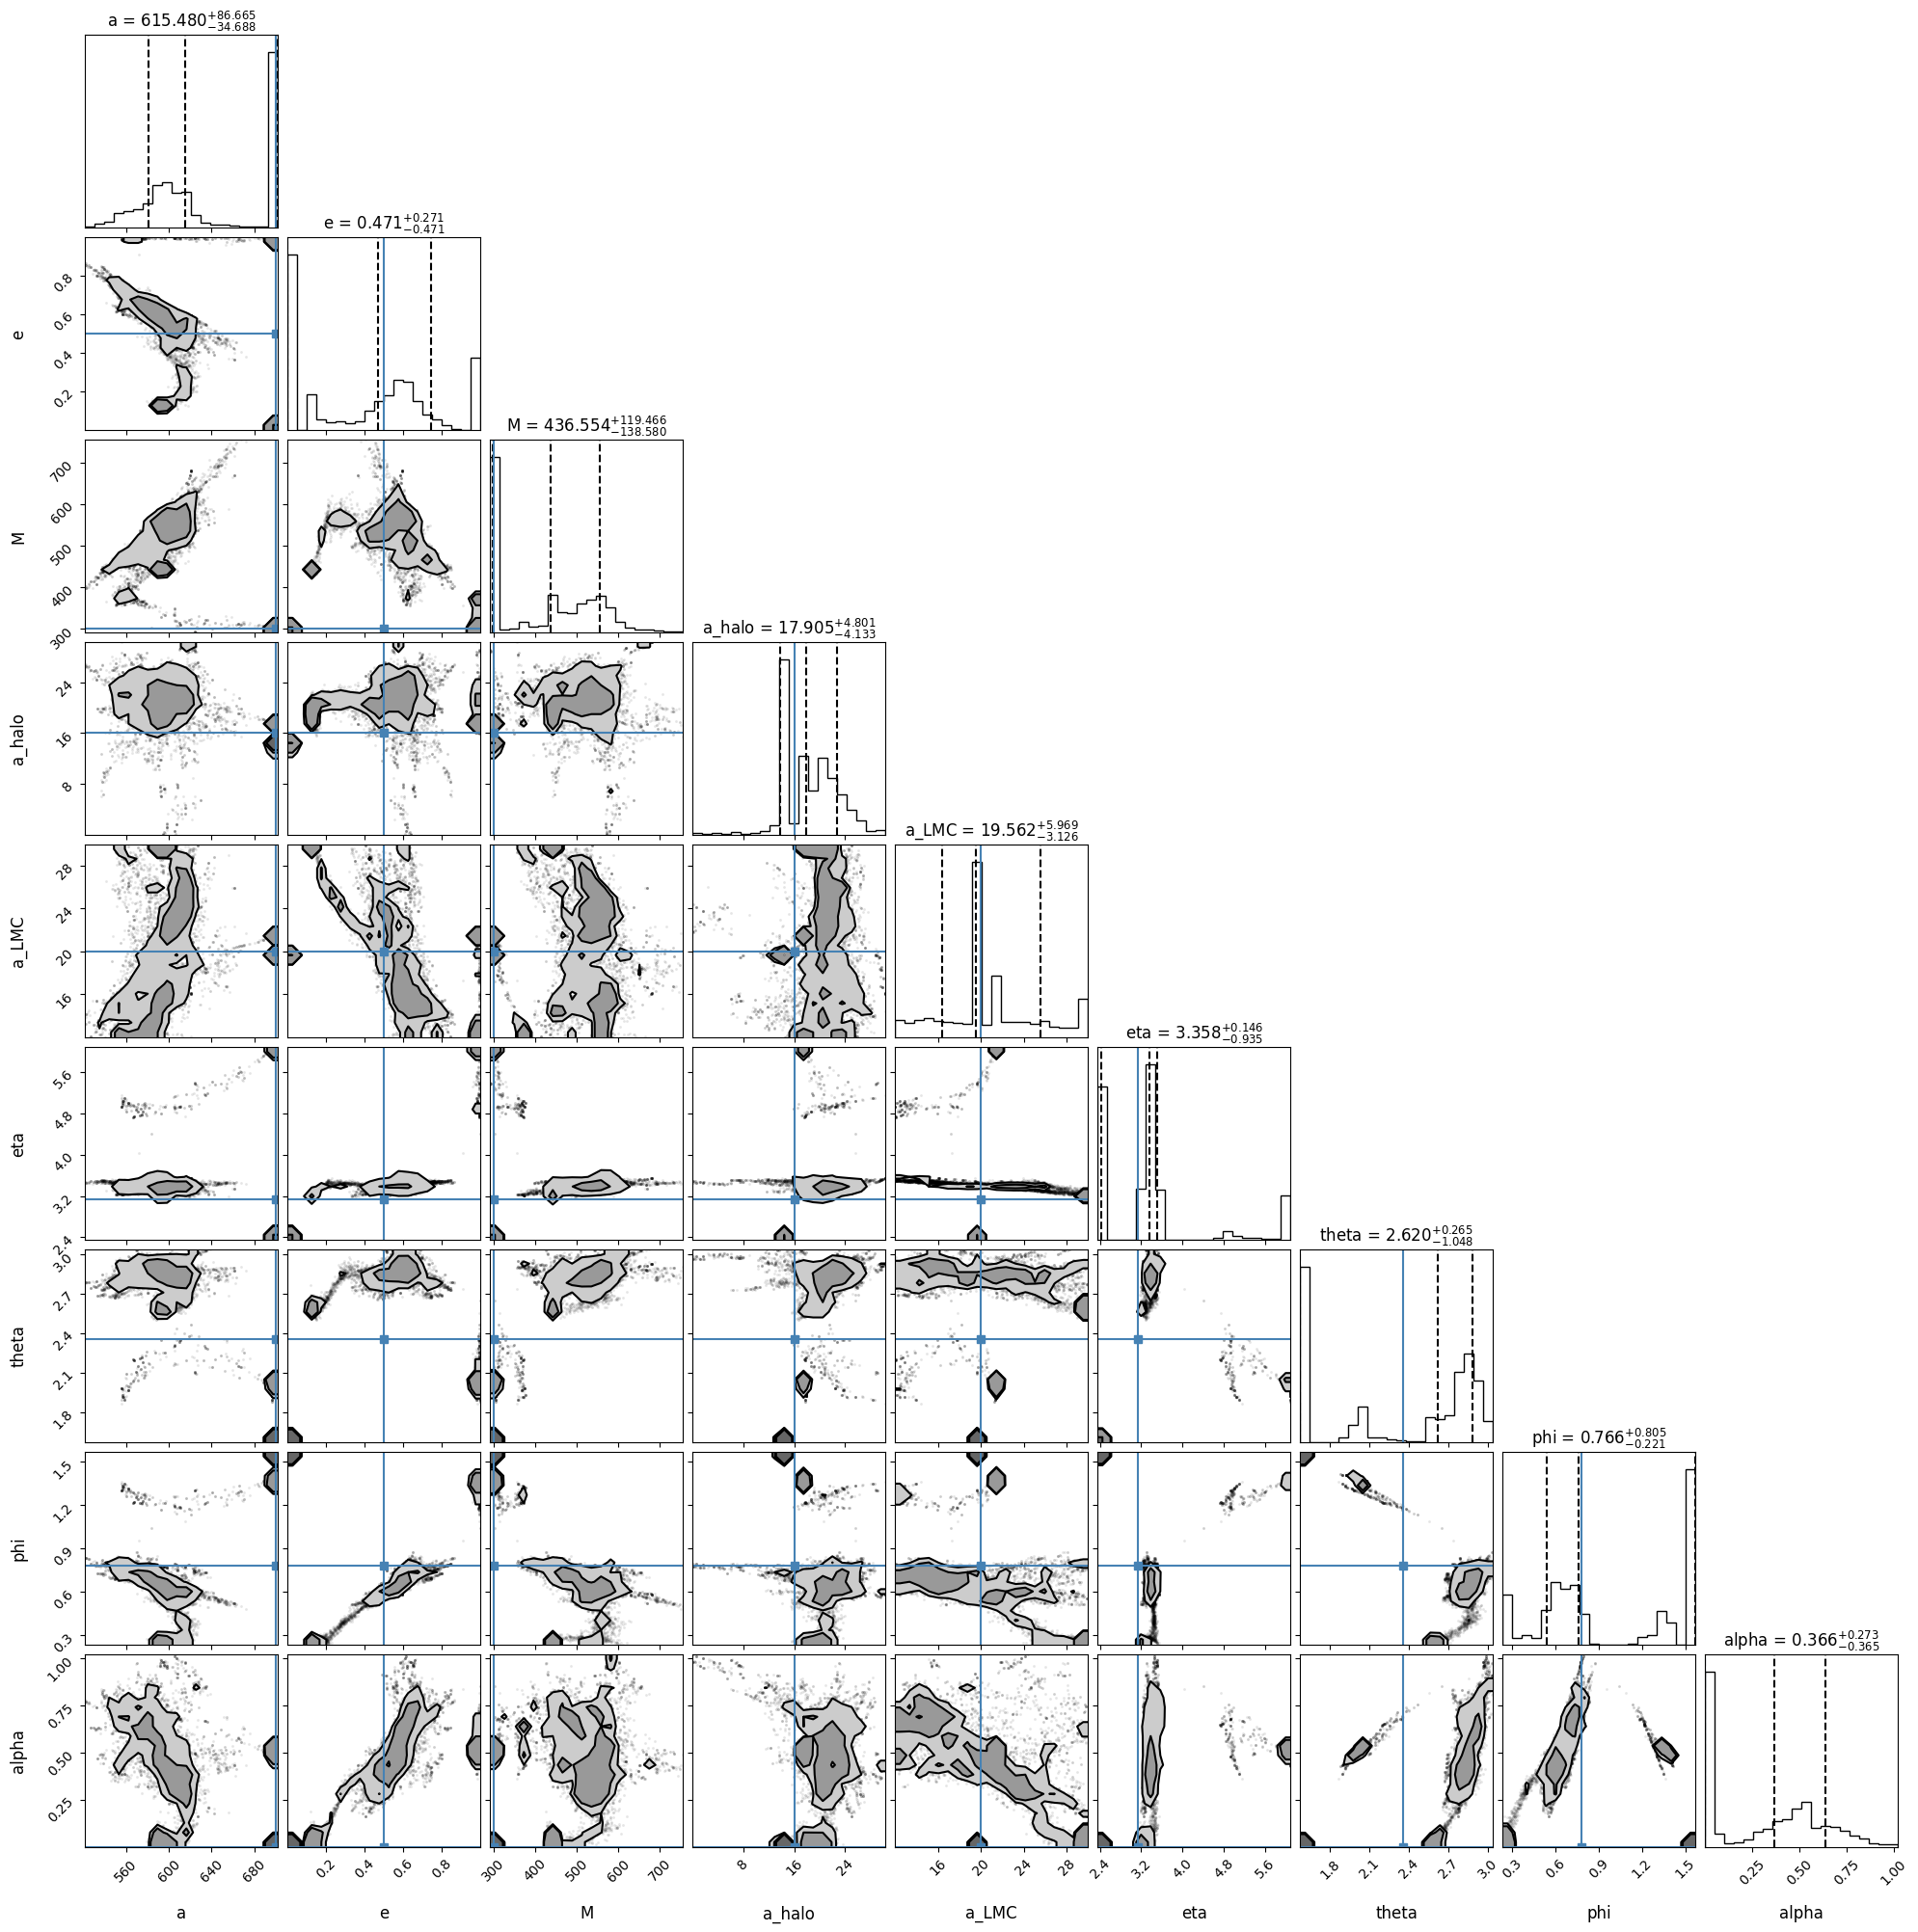

In [22]:
burn_in = int(nsteps * 0.3) 
samples = sampler.get_chain(discard=burn_in, thin=15, flat=True)

fig = corner.corner(samples, labels=["a", "e", "M", "a_halo", "a_LMC", "eta", "theta", "phi", "alpha"],
                    truths=initial_guess, quantiles=[0.16, 0.5, 0.84], show_titles=True,
                    title_kwargs={"fontsize": 12}, label_kwargs={"fontsize": 12},
                    title_fmt=".3f", fill_contours=True)

plt.show()

In [46]:
print(samples.shape)
n=11417

(20970, 9)


In [38]:
print(samples.shape)
n=22368
mod_ra = np.zeros(n)
mod_dec = np.zeros(n)
mod_distance = np.zeros(n)
mod_pmra = np.zeros(n)
mod_pmdec = np.zeros(n)
mod_vr = np.zeros(n)
mod_time = np.zeros(n)
for i in range(n):
    mod_ra[i], mod_dec[i], mod_distance[i], mod_pmra[i], mod_pmdec[i], mod_vr[i], mod_time[i] = orbit_model(samples[i])

(22368, 8)


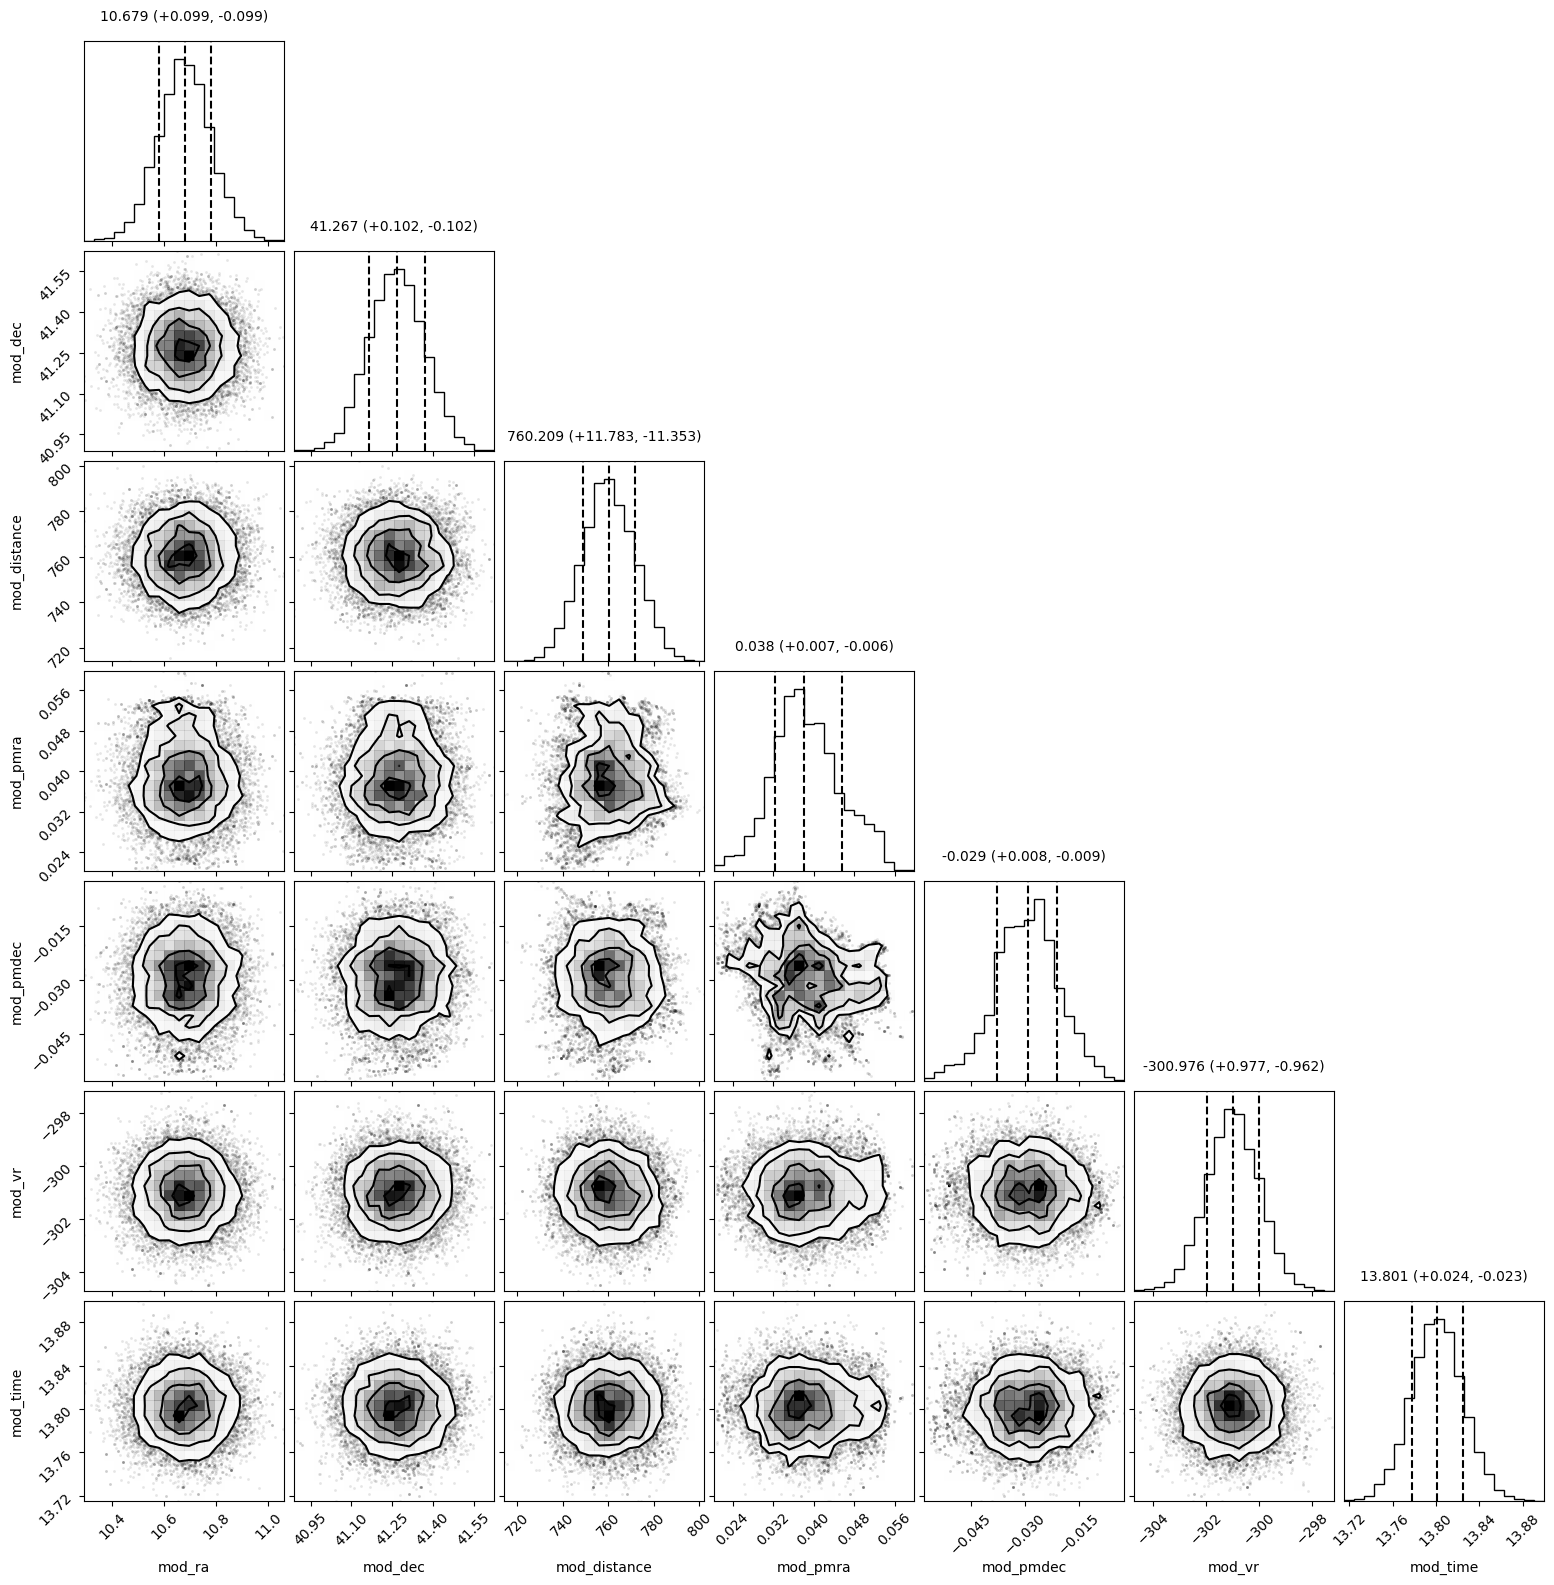

In [48]:
mods = np.c_[mod_ra, mod_dec, mod_distance, mod_pmra, mod_pmdec, mod_vr, mod_time]
mods.shape
# 参数标签和初始猜测
labels = ['mod_ra', 'mod_dec', 'mod_distance','mod_pmra', 'mod_pmdec', 'mod_vr', 'mod_time']

# 计算分位数
quantiles = [0.16, 0.5, 0.84]
percentiles = np.percentile(mods, [16, 50, 84], axis=0)

# 提取中位数和误差
medians = percentiles[1]
lower_errors = medians - percentiles[0]
upper_errors = percentiles[2] - medians

# 绘制角度分布
fig = corner.corner(mods, labels=labels,  quantiles=quantiles, fontsize=50)

# 在图中添加中位数和误差信息
axes = np.array(fig.axes).reshape((len(labels), len(labels)))
for i in range(len(labels)):
    ax = axes[i, i]
    text = f"{medians[i]:.3f} (+{upper_errors[i]:.3f}, -{lower_errors[i]:.3f})"
    ax.annotate(text, xy=(0.5, 1.1), xycoords="axes fraction", ha="center", fontsize=10)

plt.show()